In [55]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import re

In [31]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout

In [32]:
from nltk.corpus import stopwords
from nltk import word_tokenize

In [ ]:
df = pd.read_csv("data/data_all.csv")

In [ ]:
df.head()

,text,target,emotion
0,us need band together apart nevertrump promote...,0,anger
1,bain life drive cash point shop change pound c...,0,anger
2,clearly appreciate subharmonics one,1,joy
3,honestly know im unhappy time want stop itneve...,3,sadness
4,sleep cooties ni close eyes dream im awake wea...,3,sadness


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5051 entries, 0 to 5050
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     5051 non-null   object
 1   target   5051 non-null   int64 
 2   emotion  5051 non-null   object
dtypes: int64(1), object(2)
memory usage: 118.5+ KB


In [ ]:
df.emotion.value_counts()

anger       2118
sadness     1325
joy         1163
optimism     445
Name: emotion, dtype: int64

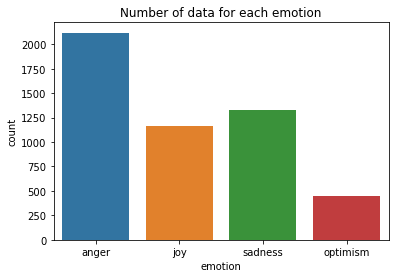

In [ ]:
sns.countplot(data=df, x="emotion")
plt.title("Number of data for each emotion")
plt.show()

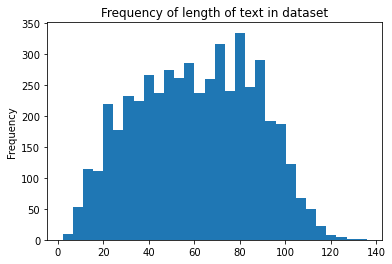

In [40]:
df["text"].apply(lambda s : len(s)).plot.hist(bins=30)
plt.title("Frequency of length of text in dataset")
plt.show()

In [41]:
def print_examples(num):
    for i in range(num):
        print(df["text"][i], end="")

In [42]:
print_examples(10)

us need band together apart nevertrump promotes hatred fuels fearbain life drive cash point shop change pound coins gym bastard sunbed grimclearly appreciate subharmonics onehonestly know im unhappy time want stop itnevergoessleep cooties ni close eyes dream im awake weary sleepissues narcolepsyuser rap reminds kids small would prepare performance cute crapuser bts trilogy mv time fav quite gloomy beautiful welluser interesting choice words confirming governments fund terrorism bit open door stilluser user heart goes woman indignity sittingim lost moment without im lost world world moment lostinthemoment

In [46]:
df = df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words("english"))

def clean_text(text):
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    return text

df["text"] = df["text"].apply(clean_text)

In [47]:
df["text"]

0       us need band together apart nevertrump promote...
1       bain life drive cash point shop change pound c...
2                     clearly appreciate subharmonics one
3       honestly know im unhappy time want stop itneve...
4       sleep cooties ni close eyes dream im awake wea...
                              ...                        
5046    user yeah heart evil speech reflected says lot...
5047    gadot please put left turn signal williams iva...
5048    kayaking merriment together sevylor inflatable...
5049    user charlotteprotest u wait facts video u hat...
5050    everything see american police training seems ...
Name: text, Length: 5051, dtype: object

In [49]:
df["text"] = df["text"].str.replace('\d+', '', regex=True)

In [50]:
print_examples(10)

us need band together apart nevertrump promotes hatred fuels fearbain life drive cash point shop change pound coins gym bastard sunbed grimclearly appreciate subharmonics onehonestly know im unhappy time want stop itnevergoessleep cooties ni close eyes dream im awake weary sleepissues narcolepsyuser rap reminds kids small would prepare performance cute crapuser bts trilogy mv time fav quite gloomy beautiful welluser interesting choice words confirming governments fund terrorism bit open door stilluser user heart goes woman indignity sittingim lost moment without im lost world world moment lostinthemoment

In [51]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df["text"].values)
word_index = tokenizer.word_index
print(f"Found %s unique tokens. {len(word_index)}")

Found %s unique tokens. 11145


In [60]:
dict(itertools.islice(word_index.items(), 10))

{'user': 1,
 'im': 2,
 'like': 3,
 'n': 4,
 'get': 5,
 'amp': 6,
 'people': 7,
 'one': 8,
 'know': 9,
 'u': 10}

In [61]:
X = tokenizer.texts_to_sequences(df["text"].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (5051, 250)


In [62]:
Y = pd.get_dummies(df["emotion"]).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (5051, 4)


In [63]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.30, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(3535, 250) (3535, 4)
(1516, 250) (1516, 4)


In [64]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(4, activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 250, 100)          5000000   
                                                                 
 spatial_dropout1d_2 (Spatia  (None, 250, 100)         0         
 lDropout1D)                                                     
                                                                 
 lstm_2 (LSTM)               (None, 100)               80400     
                                                                 
 dense_2 (Dense)             (None, 4)                 404       
                                                                 
Total params: 5,080,804
Trainable params: 5,080,804
Non-trainable params: 0
_________________________________________________________________
None


In [65]:
epochs = 10
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor="val_loss", patience=3, min_delta=0.0001)])

Epoch 1/10
45/45 [==============================] - 17s 319ms/step - loss: 1.2899 - accuracy: 0.4155 - val_loss: 1.2602 - val_accuracy: 0.3975
Epoch 2/10
45/45 [==============================] - 15s 332ms/step - loss: 1.1392 - accuracy: 0.4950 - val_loss: 1.0490 - val_accuracy: 0.6068
Epoch 3/10
45/45 [==============================] - 15s 331ms/step - loss: 0.6401 - accuracy: 0.7924 - val_loss: 0.8906 - val_accuracy: 0.6620
Epoch 4/10
45/45 [==============================] - 15s 327ms/step - loss: 0.3148 - accuracy: 0.8879 - val_loss: 0.9279 - val_accuracy: 0.6789
Epoch 5/10
45/45 [==============================] - 15s 341ms/step - loss: 0.1514 - accuracy: 0.9576 - val_loss: 0.9319 - val_accuracy: 0.6634
Epoch 6/10
45/45 [==============================] - 15s 332ms/step - loss: 0.1054 - accuracy: 0.9763 - val_loss: 1.0675 - val_accuracy: 0.6818


In [66]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

48/48 [==============================] - 2s 41ms/step - loss: 1.0840 - accuracy: 0.6629
Test set
  Loss: 1.084
  Accuracy: 0.663


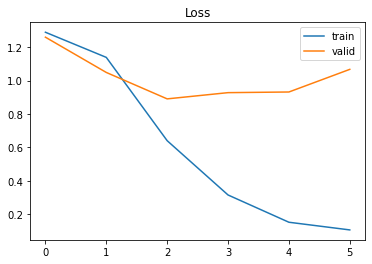

In [69]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.legend()
plt.show();

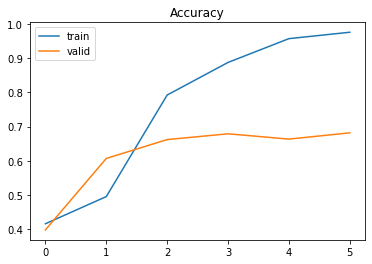

In [70]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='valid')
plt.legend()
plt.show();

In [ ]:
new_complaint = ["We're rooting for you to recover well and fully!"]
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
labels = list(df["emotion"].unique())
print(pred, labels[np.argmax(pred)])

[[0.31720334 0.31219545 0.138336   0.2322652 ]] anger
